Build CNN Classifier using Simulation data and test it using real images
==============================================================

Get Train and Test data using the simulation
----------------------------------------------

Training data should be aquired of the switch on the granite table and then run though the extract target process.

Train CNN
-----------

In [1]:
# Parameters
data_dir = 'data/bags/2024-03-21_tim/bsharp/Fixed/data_for_CNN_training/target_1/'  # specify data path
classes = ['off', 'on']  # specify the image classes
num_epochs = 45  # number of epochs to train
model_name = 'switch_model_cnn.pt'  # saved model name
trace_model_name = 'traced_model_cnn.pt'  # saved traced model name

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
from PIL import Image
from torch import nn, optim
from torchvision import datasets, models, transforms

torch.cuda.is_available()

True

In [3]:
# Define transforms for the training data and testing data

# Transform the training dataset, this helps us get a more robust model
train_transforms = transforms.Compose(
    [
        transforms.Resize([256, 256]), 
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224, scale=(0.35, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Transform the test dataset to match the training dataset, the transforms are more limited on the test set
test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

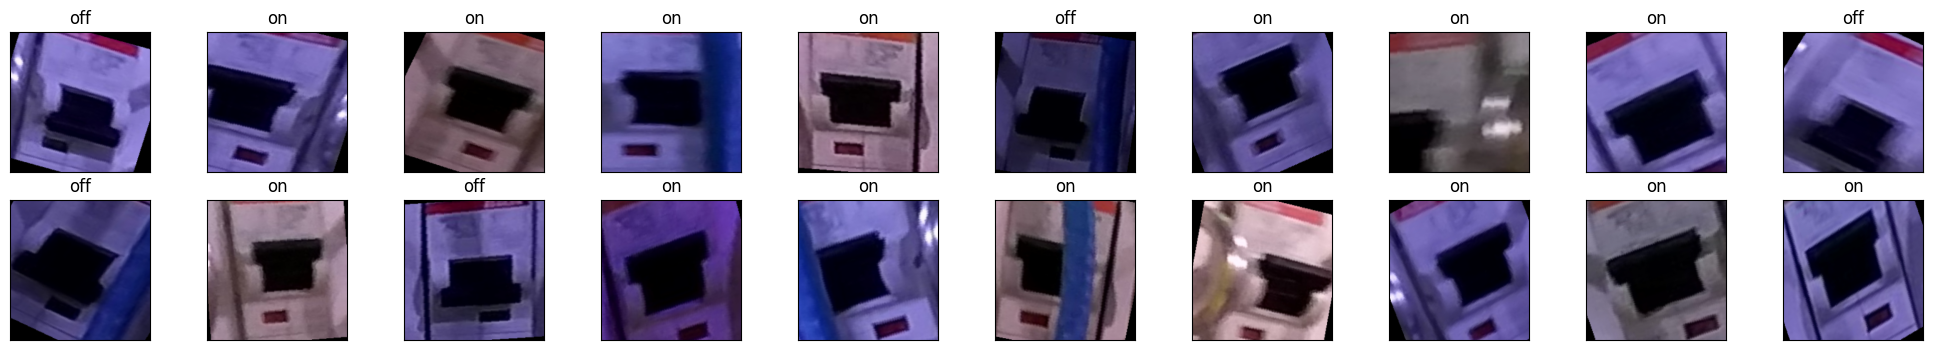

In [4]:

# Visualize some of the data-----------------------
# helper function to un-normalize and display an image
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to be in the valid range
    npimg = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(npimg)


# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [5]:

# Use GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1),
)

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [6]:
model.to(device)

epochs = num_epochs
steps = 0
running_loss = 0
print_every = 5
test_loss_min = np.Inf
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(
                'Epoch ',
                epoch + 1,
                '/',
                epochs,
                '.. ' 'Train loss: ',
                running_loss / print_every,
                '.. ' 'Test loss: ',
                test_loss / len(testloader),
                '.. ' 'Test accuracy: ',
                accuracy / len(testloader),
                '',
            )
            running_loss = 0

            # save model if validation loss has decreased
            if test_loss <= test_loss_min:
                torch.save(model.state_dict(), model_name)
                test_loss_min = test_loss

                model.to('cpu')
                # An example input you would normally provide to your model's forward() method.
                example = torch.rand(1, 3, 224, 224)
                # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
                traced_script_module = torch.jit.trace(model, example)
                output = traced_script_module(torch.ones(1, 3, 224, 224))
                print(output)
                traced_script_module.save(trace_model_name)
                model.to(device)

            model.train()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch  2 / 45 .. Train loss:  1.0909703135490418 .. Test loss:  0.6449247598648071 .. Test accuracy:  0.8723404407501221 
tensor([[-0.7130, -0.6737]], grad_fn=<LogSoftmaxBackward0>)
Epoch  4 / 45 .. Train loss:  0.6073055148124695 .. Test loss:  0.4061216413974762 .. Test accuracy:  0.8297872543334961 
tensor([[-1.1893, -0.3630]], grad_fn=<LogSoftmaxBackward0>)
Epoch  5 / 45 .. Train loss:  0.5505567193031311 .. Test loss:  0.4283740222454071 .. Test accuracy:  0.8297872543334961 
Epoch  7 / 45 .. Train loss:  0.5044606685638428 .. Test loss:  0.32857269048690796 .. Test accuracy:  0.8297872543334961 
tensor([[-0.9202, -0.5083]], grad_fn=<LogSoftmaxBackward0>)
Epoch  9 / 45 .. Train loss:  0.45973787903785707 .. Test loss:  0.28290969133377075 .. Test accuracy:  0.8723404407501221 
tensor([[-0.8697, -0.5431]], grad_fn=<LogSoftmaxBackward0>)
Epoch  10 / 45 .. Train loss:  0.401563835144043 .. Test loss:  0.23614366352558136 .. Test accuracy:  0.8723404407501221 
tensor([[-0.8552, -0.553

Validate Result using Real data
------------------------------

To validate the results using real data, let's use an image collected during ISS operations

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets, models, transforms

# Open and display image
image = Image.open('data/bags/2024-03-21_tim/bsharp/Fixed/data_for_CNN_training/target_1/')
imgplot = plt.imshow(image)
plt.show()

# Open model
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1),
)
model.load_state_dict(torch.load('switch_model_cnn.pt'))
model.eval()

# Classify Image!
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
output = model(image_tensor)

# Print Result
_, predicted = torch.max(output, 1)
print('Classification: ', classes[predicted])


## Model failure analysis

This section looks as the cases where the model failed to classify the switch correc

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Identify misclassified indices
misclassified_indices = np.where(all_preds != all_labels)[0]

# Print the number of misclassifications
num_misclassifications = len(misclassified_indices)
print(f'Number of misclassifications: {num_misclassifications}')

print(f'Total test samples: {len(test_data)}')
print(f'Number of batches: {len(testloader)}')

In [ ]:
# Used to denormalize the images so the user can view them
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

# Plots the images where the model got it wrong
def plot_misclassified_images(dataset, indices, true_labels, predicted_labels, mean, std, num_images=10):
    plt.figure(figsize=(20, 20))
    for i, index in enumerate(indices[:num_images]):
        plt.subplot(5, 2, i + 1)
        image, _ = dataset[index]
        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
        plt.imshow(image)
        plt.title(f'True: {true_labels[index]}, Pred: {predicted_labels[index]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define the normalization parameters used during preprocessing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Plot some of the misclassified images
plot_misclassified_images(test_data, misclassified_indices, all_labels, all_preds, mean, std)